# Terminal commands for data access

```
autossh -AtX vschuma@ssh1.mdc-berlin.de ssh vschuma@murphy.mdc-berlin.net
# open the ssh screen and/or type
ssh -NR 6667:localhost:22 vfs@79.197.179.128 (current network ID)

# mount
sshfs -p 6667 vschuma@localhost:/data/local/rajewsky/home/vschuma /mnt/murphy_workspace/
or
sshfs vschuma@murphy:/data/local/rajewsky/home/vschuma/ ~/mounts/murphy_workspace/

# if working with the mount is to slow, copy the data to a ramdisk
sudo mount -t tmpfs -o size=6g tmpfs /mnt/ramdisk/

# then copy the file to the ramdisk
mkdir /mnt/ramdisk/data && rsync -av /mnt/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /mnt/ramdisk/data
or
mkdir /dev/shm/data && rsync -av /home/vschuma/mounts/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /dev/shm/data/
# symlink inside the pycharm project to the data dir
(example command)
ln -s /mnt/ramdisk/data data
e.g.: ln -s /mnt/murphy_workspace/NSTT/data/ data
or
ln -s /dev/shm/data/ data
```

# Imports

In [84]:
from importlib import reload

import anndata
from bokeh.layouts import column
%matplotlib inline
import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import zscore
from sklearn import preprocessing

import random

# Notebook location

In [3]:
os.getcwd()

'/home/vschuma/PycharmProjects/novosparc/Vic/development'

# Data read in

I use the mouse brain data set used in [this squidpy tutorial](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_visium_hne.html#sphx-glr-auto-tutorials-tutorial-visium-hne-py).
The preprocessing (atlas creation, dge and cell type extraction was done in the `data_for_celltype_transfer_tesing` notebook.

## atlas and dge
Note that in this case (bc taken from visium data) there are as many (pseudo) cells as locations.

In [4]:
# atlas settings
atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, '10x_MouseBrain_coordinates.csv')
locations = pd.read_csv(target_space_path, sep=',')
num_locations = locations.shape[0] # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori

# if the above creates problems when merging with adata try this one:
# locations_apriori = locations[:num_locations][['xcoord', 'ycoord']]
# locations = np.asarray(locations_apriori)
atlas_path = os.path.join(atlas_dir, 'mouse_brain_test_atlas.csv')
# atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why

chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
print(len(atlas_genes))
print(atlas.shape)
print(locations.shape)
atlas.obsm['spatial'] = locations
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'data/'
data_path = os.path.join(data_dir, '10x_MouseBrain_dge.csv')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

<ipython-input-4-126ef26f36f4>:17: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atlas = sc.AnnData(df)
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


49
(2688, 49)
(2688, 2)
number of cells: 2688
number of genes: 18078


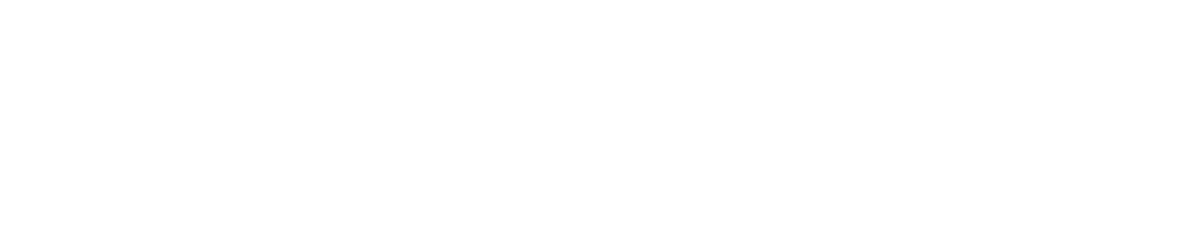

<Figure size 432x288 with 0 Axes>

In [5]:
pl_genes = ["Spock1", "Cacna2d3", "Atp1a3"]
novosparc.pl.embedding(atlas, pl_genes)

## meta data

In [6]:
meta_data_dir = 'data'
meta_ct_path = os.path.join(meta_data_dir, "mouse_brain_meta_ct.csv")

cell_types_raw = pd.read_csv(meta_ct_path)
cell_type = np.asarray(cell_types_raw)

In [7]:
cell_type

array([['Cortex_2'],
       ['Cortex_5'],
       ['Thalamus_2'],
       ...,
       ['Hypothalamus_1'],
       ['Thalamus_2'],
       ['Cortex_4']], dtype=object)

# Reconstruction
## create tissue object

In [8]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


# setup smooth
num_neighbors_s = num_neighbors_t = 5

# alternative 1: setup both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.1
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Setting up for reconstruction ... done ( 20.49 seconds )
Reconstructing spatial information with 49 markers: 2688 cells and 2688 locations ... 
Trying with epsilon: 5.00e-03


/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Trying with epsilon: 5.00e-03


# meta data transfer
## prepare gw matrix

In [9]:
gw_matrix = pd.DataFrame(tissue.gw)
type(gw_matrix)
gw_matrix.shape[0]

2688

# use one-hot encoding

## merge celltype with gw

In [10]:
print(cell_types_raw.shape)
print(gw_matrix.shape)
ct_gw_merge = gw_matrix.join(cell_types_raw)
print(ct_gw_merge.shape)
print(ct_gw_merge[:3])

(2688, 1)
(2688, 2688)
(2688, 2689)
              0             1             2             3             4  \
0  2.701208e-04  3.348031e-08  1.507369e-09  8.653892e-09  5.465680e-08   
1  8.724890e-08  3.303724e-04  9.761795e-10  1.574889e-08  4.071276e-08   
2  1.245076e-08  1.215929e-09  2.445821e-04  2.167522e-09  2.195145e-08   

              5             6             7             8             9  ...  \
0  3.279965e-08  9.199188e-08  1.024672e-07  2.494766e-08  1.655856e-08  ...   
1  6.238084e-09  3.037482e-08  1.572673e-08  9.122858e-09  2.098506e-09  ...   
2  7.151629e-08  3.177913e-08  2.467006e-09  4.125608e-09  1.936125e-07  ...   

           2679          2680          2681          2682          2683  \
0  4.688604e-08  5.440548e-08  5.037407e-09  9.415611e-09  3.446722e-08   
1  1.024142e-08  1.196148e-08  2.130287e-09  5.181170e-09  1.320323e-08   
2  1.411509e-07  1.840865e-07  1.691888e-08  1.086672e-10  2.433456e-08   

           2684          2685          26

## encode cell types

In [11]:
ct_unique = np.unique(cell_type)
print(ct_unique, len(ct_unique))

['Cortex_1' 'Cortex_2' 'Cortex_3' 'Cortex_4' 'Cortex_5' 'Fiber_tract'
 'Hippocampus' 'Hypothalamus_1' 'Hypothalamus_2' 'Lateral_ventricle'
 'Pyramidal_layer' 'Pyramidal_layer_dentate_gyrus' 'Striatum' 'Thalamus_1'
 'Thalamus_2'] 15


In [12]:
onehot = pd.get_dummies(cell_types_raw)

## multiply gw and ct

In [13]:
print(gw_matrix.shape) # cells x locations

ct_gw_merge = np.dot(gw_matrix.T, onehot)
print(ct_gw_merge.shape) # locations x ct

(2688, 2688)
(2688, 15)


## adding the matrix  to the tissue object

In [14]:
ctgw_df = pd.DataFrame(ct_gw_merge, columns=ct_unique)
tissue.ctgw = ctgw_df # celltypes are the columns

# Plotting

1. per celltype visu: 1 color, mapping probability is encoded by alpha value of the color
2. celltype mixture mapping visu: as many colors as celltypes, every location get's the celltype value with the highest probability value

In [15]:
# ToDo

ct_test = ['Hippocampus','Cortex_3', 'Striatum']
dataset_tissue = sc.AnnData(tissue.ctgw, dtype=float)
dataset_tissue.obsm['spatial'] = locations

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [74]:
type(locations)

numpy.ndarray

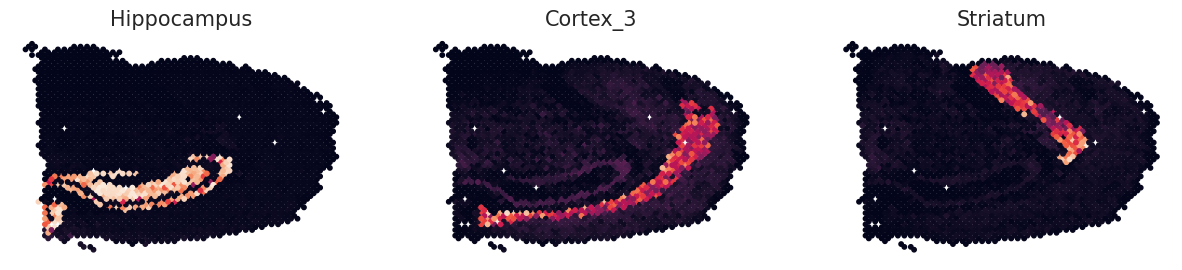

<Figure size 432x288 with 0 Axes>

In [16]:
novosparc.pl.embedding(dataset_tissue, ct_test)

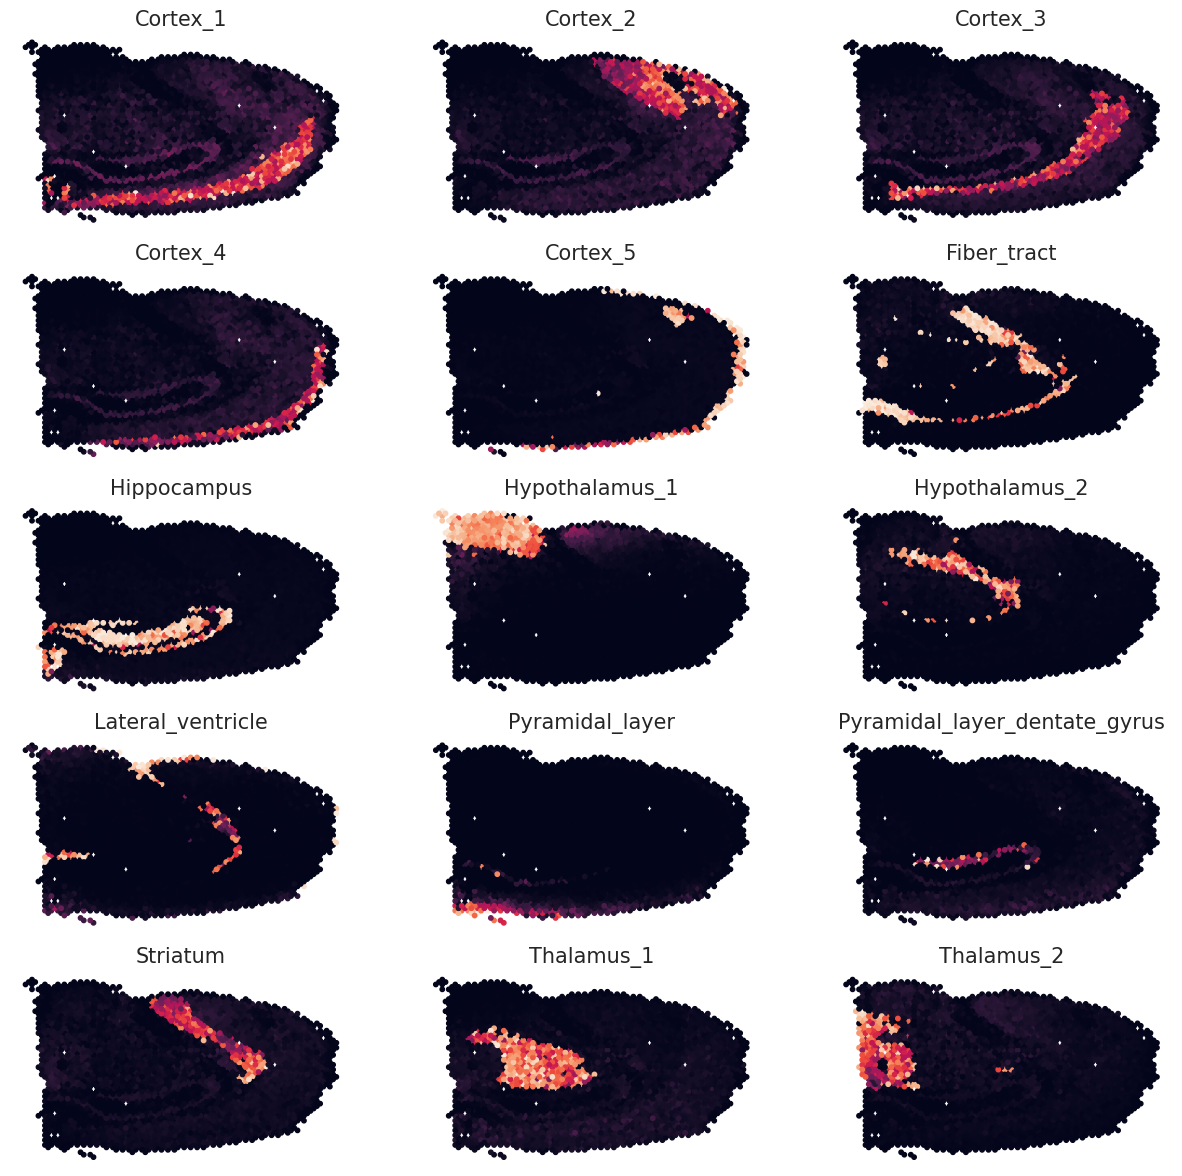

<Figure size 432x288 with 0 Axes>

In [17]:
novosparc.pl.embedding(dataset_tissue, ct_unique)

# check diversity of gw

In [18]:
tissue.gw[0]

array([2.70120766e-04, 3.34803070e-08, 1.50736948e-09, ...,
       2.58308818e-09, 4.78652682e-08, 6.17669900e-08])

# Plot all annotations in one plot

## 1. filter the annotation with the highest probability per location (maybe the prob value too)

In [ ]:
# init a data frame with 2 columns: mapped_ct  & mapping_value
mapped_meta_df = pd.DataFrame(columns=["mapped_ct",
                                       "mapping_value_ct"])
# need to do this in an iterative way later (for multiple meta data classes) would be smth like:
# df = pd.DataFrame(columns=['colname_' + str(i) for i in range(5)])

In [53]:
# loop over tissue.ctgw rowwise

# find max value in the row
out_array = np.amax(np.array(tissue.ctgw), axis=1)
# find the values column name - get the index
out_array = np.vstack((out_array, np.argmax(np.array(tissue.ctgw), axis=1)))

In [56]:

# transform to df to enable multiple data types
out_df = pd.DataFrame(out_array.T)
print(out_df.shape)

(2688, 2)


In [59]:
%%time
# write value and column name into the new df
# can I add a new column like this? - yes, but it takes already quite some time
out_df[2] = out_df[1].apply(lambda x: tissue.ctgw.columns[x])
out_df.columns = ["mapping_prop_ct", "mapped_ct_idx", "mapped_ct"]

In [81]:
# add annotation to the dataset anndata
dataset_tissue.obsm["mapped_ct"] = out_df["mapped_ct"].to_numpy().reshape(-1,1)
dataset_tissue.obsm["mapping_prop_ct"] = out_df["mapping_prop_ct"].to_numpy().reshape(-1,1)

In [86]:
sq.pl.spatial_scatter(dataset_tissue, color="mapped_ct")

KeyError: "Spatial key 'spatial' not found in `adata.uns`."

### different ideas for filling a dataframe through a loop
Collections of ways to do it. Would have to test which of them is the fastest and most memory efficant one. I think it makes sense to do this already since those df tend to be quite big.


1. in the loop create a list of list and only later transform that list into a df
```
import pandas as pd
list_of_lists = []
list_of_lists.append([1,2,3])
list_of_lists.append([4,5,6])

pd.DataFrame(list_of_lists, columns=['A', 'B', 'C'])
#    A  B  C
# 0  1  2  3
# 1  4  5  6
```
2. use a simple loop to write into a previously initialized df
```
df = pd.DataFrame(columns=('col1', 'col2', 'col3'))
for i in range(5):
   df.loc[i] = ['<some value for first>','<some value for second>','<some value for third>']`
```
3. create a dict in the loop and concat that into a df
```
df = pd.DataFrame(columns=["firstname", "lastname"])

entry = pd.DataFrame.from_dict({
     "firstname": ["John"],
     "lastname":  ["Johny"]
})

df = pd.concat([df, entry], ignore_index=True)
```
4. do a row by row thing using a series
```
df = pd.DataFrame(columns=['a','b','c','d'], index=['x','y','z'])

df.loc['y'] = pd.Series({'a':1, 'b':5, 'c':2, 'd':3})
```

### Article about speed comparisons of pandas functions
[ --> Architecture & Performance](https://www.architecture-performance.fr/ap_blog/applying-a-row-wise-function-to-a-pandas-dataframe/)

In [4]:
os.getcwd()

'/home/vfs/PycharmProjects/rajewskyLab/novosparc/Vic/development'

# Data read in

I use the mouse brain data set used in [this squidpy tutorial](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_visium_hne.html#sphx-glr-auto-tutorials-tutorial-visium-hne-py).
The preprocessing (atlas creation, dge and cell type extraction was done in the `data_for_celltype_transfer_tesing` notebook.

## atlas and dge
Note that in this case (bc taken from visium data) there are as many (pseudo) cells as locations.

In [29]:
# atlas settings
atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, '10x_MouseBrain_coordinates.csv')
locations = pd.read_csv(target_space_path, sep=',')
num_locations = locations.shape[0] # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori

# if the above creates problems when merging with adata try this one:
# locations_apriori = locations[:num_locations][['xcoord', 'ycoord']]
# locations = np.asarray(locations_apriori)
atlas_path = os.path.join(atlas_dir, 'mouse_brain_test_atlas.csv')
# atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why

chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
print(len(atlas_genes))
print(atlas.shape)
print(locations.shape)
atlas.obsm['spatial'] = locations
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'data/'
data_path = os.path.join(data_dir, '10x_MouseBrain_dge.csv')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

number of cells: 2688
number of genes: 18078


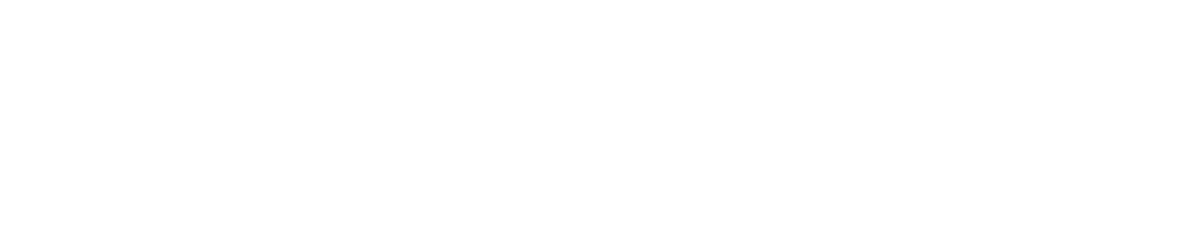

<Figure size 432x288 with 0 Axes>

In [58]:
pl_genes = ["Spock1", "Cacna2d3", "Atp1a3"]
novosparc.pl.embedding(atlas, pl_genes)

## meta data

In [30]:
meta_data_dir = 'data'
meta_ct_path = os.path.join(meta_data_dir, "mouse_brain_meta_ct.csv")

cell_types_raw = pd.read_csv(meta_ct_path)
cell_type = np.asarray(cell_types_raw)

In [32]:
cell_type

array([['Cortex_2'],
       ['Cortex_5'],
       ['Thalamus_2'],
       ...,
       ['Hypothalamus_1'],
       ['Thalamus_2'],
       ['Cortex_4']], dtype=object)

# Reconstruction
## create tissue object

In [48]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


# setup smooth
num_neighbors_s = num_neighbors_t = 5

# alternative 1: setup both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.1
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Setting up for reconstruction ... done ( 17.17 seconds )
Reconstructing spatial information with 49 markers: 2688 cells and 2688 locations ... 
Trying with epsilon: 5.00e-03


/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Trying with epsilon: 5.00e-03


# meta data transfer
## prepare gw matrix

In [49]:
gw_matrix = pd.DataFrame(tissue.gw)
type(gw_matrix)
gw_matrix.shape[0]

2688

# use one-hot encoding

## merge celltype with gw

In [50]:
print(cell_types_raw.shape)
print(gw_matrix.shape)
ct_gw_merge = gw_matrix.join(cell_types_raw)
print(ct_gw_merge.shape)
print(ct_gw_merge[:3])

(2688, 1)
(2688, 2688)
(2688, 2689)
              0             1             2             3             4  \
0  2.701208e-04  3.348031e-08  1.507369e-09  8.653892e-09  5.465680e-08   
1  8.724890e-08  3.303724e-04  9.761795e-10  1.574889e-08  4.071276e-08   
2  1.245076e-08  1.215929e-09  2.445821e-04  2.167522e-09  2.195145e-08   

              5             6             7             8             9  ...  \
0  3.279965e-08  9.199188e-08  1.024672e-07  2.494766e-08  1.655856e-08  ...   
1  6.238084e-09  3.037482e-08  1.572673e-08  9.122858e-09  2.098506e-09  ...   
2  7.151629e-08  3.177913e-08  2.467006e-09  4.125608e-09  1.936125e-07  ...   

           2679          2680          2681          2682          2683  \
0  4.688604e-08  5.440548e-08  5.037407e-09  9.415611e-09  3.446722e-08   
1  1.024142e-08  1.196148e-08  2.130287e-09  5.181170e-09  1.320323e-08   
2  1.411509e-07  1.840865e-07  1.691888e-08  1.086672e-10  2.433456e-08   

           2684          2685          26

## encode cell types

In [51]:
ct_unique = np.unique(cell_type)
print(ct_unique, len(ct_unique))

['Cortex_1' 'Cortex_2' 'Cortex_3' 'Cortex_4' 'Cortex_5' 'Fiber_tract'
 'Hippocampus' 'Hypothalamus_1' 'Hypothalamus_2' 'Lateral_ventricle'
 'Pyramidal_layer' 'Pyramidal_layer_dentate_gyrus' 'Striatum' 'Thalamus_1'
 'Thalamus_2'] 15


In [52]:
onehot = pd.get_dummies(cell_types_raw)

## multiply gw and ct

In [53]:
print(gw_matrix.shape) # cells x locations

ct_gw_merge = np.dot(gw_matrix.T, onehot)
print(ct_gw_merge.shape) # locations x ct

(2688, 2688)
(2688, 15)


## adding the matrix  to the tissue object

In [54]:
ctgw_df = pd.DataFrame(ct_gw_merge, columns=ct_unique)
tissue.ctgw = ctgw_df # celltypes are the columns

# Plotting

1. per celltype visu: 1 color, mapping probability is encoded by alpha value of the color
2. celltype mixture mapping visu: as many colors as celltypes, every location get's the celltype value with the highest probability value

In [55]:
# ToDo

ct_test = ['Hippocampus','Cortex_3', 'Striatum']
dataset_tissue = sc.AnnData(tissue.ctgw, dtype=float)
dataset_tissue.obsm['spatial'] = locations

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


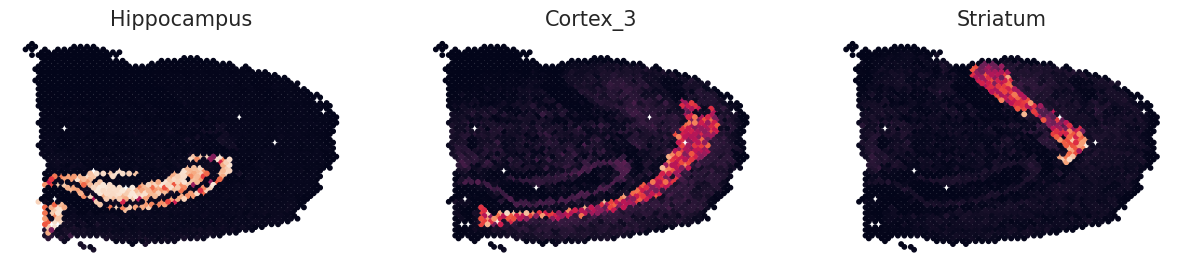

<Figure size 432x288 with 0 Axes>

In [56]:
novosparc.pl.embedding(dataset_tissue, ct_test)

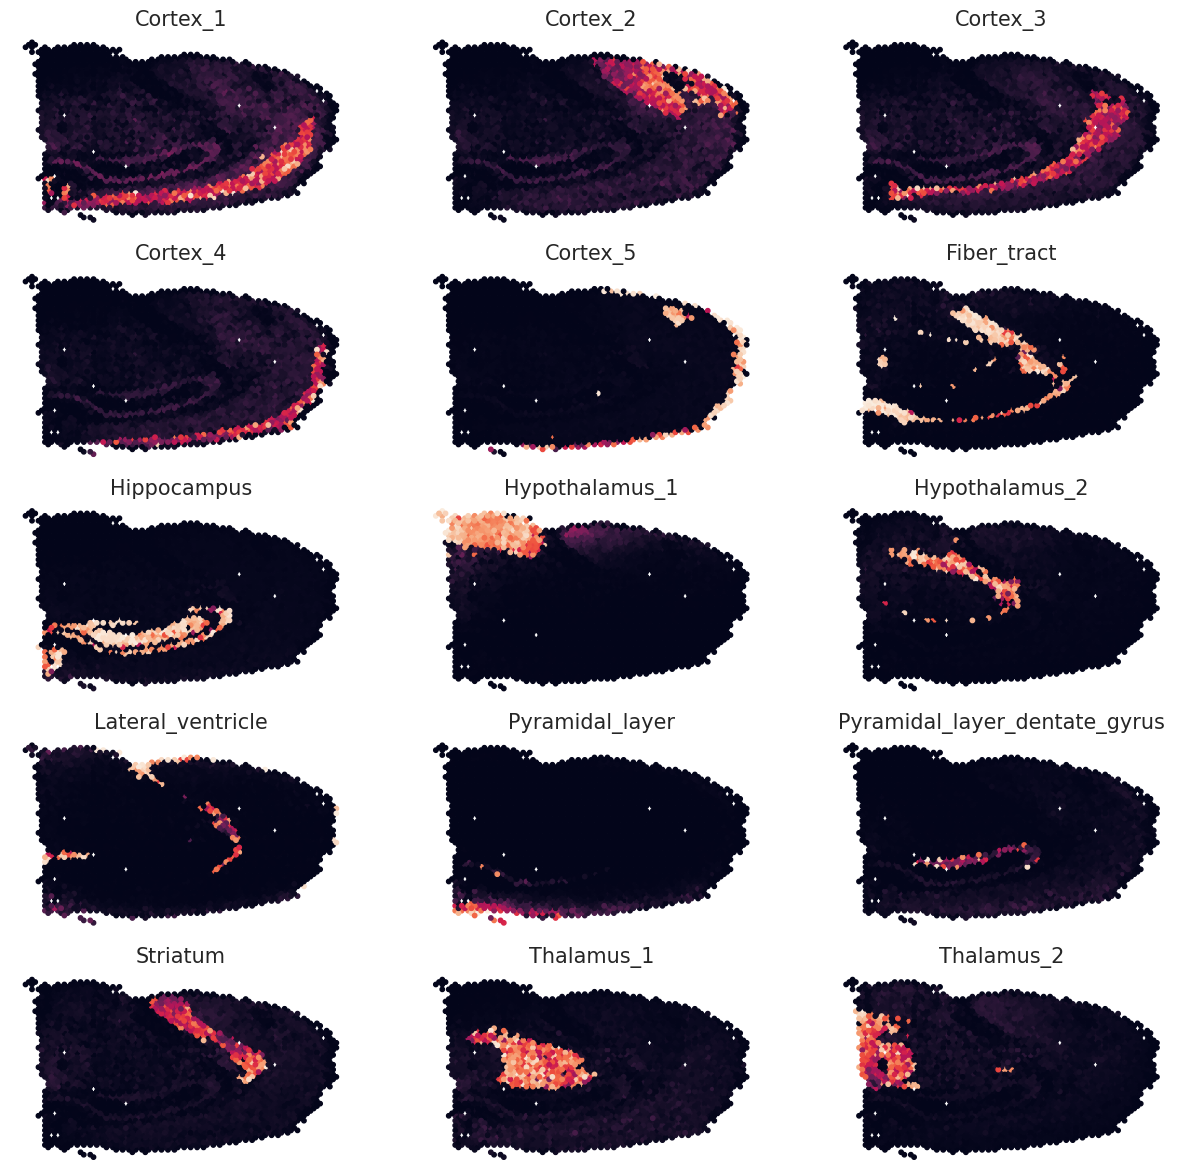

<Figure size 432x288 with 0 Axes>

In [60]:
novosparc.pl.embedding(dataset_tissue, ct_unique)

# check diversity of gw

In [59]:
tissue.gw[0]

array([2.70120766e-04, 3.34803070e-08, 1.50736948e-09, ...,
       2.58308818e-09, 4.78652682e-08, 6.17669900e-08])